In [1]:
# => makes the plot interactive
%matplotlib notebook 
# inline makes the plots static
#%matplotlib inline 

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import warnings
# filter astropy warning on fits headers
warnings.filterwarnings('ignore', category=UserWarning, append=True)
from spectro_tools import *

<IPython.core.display.Javascript object>


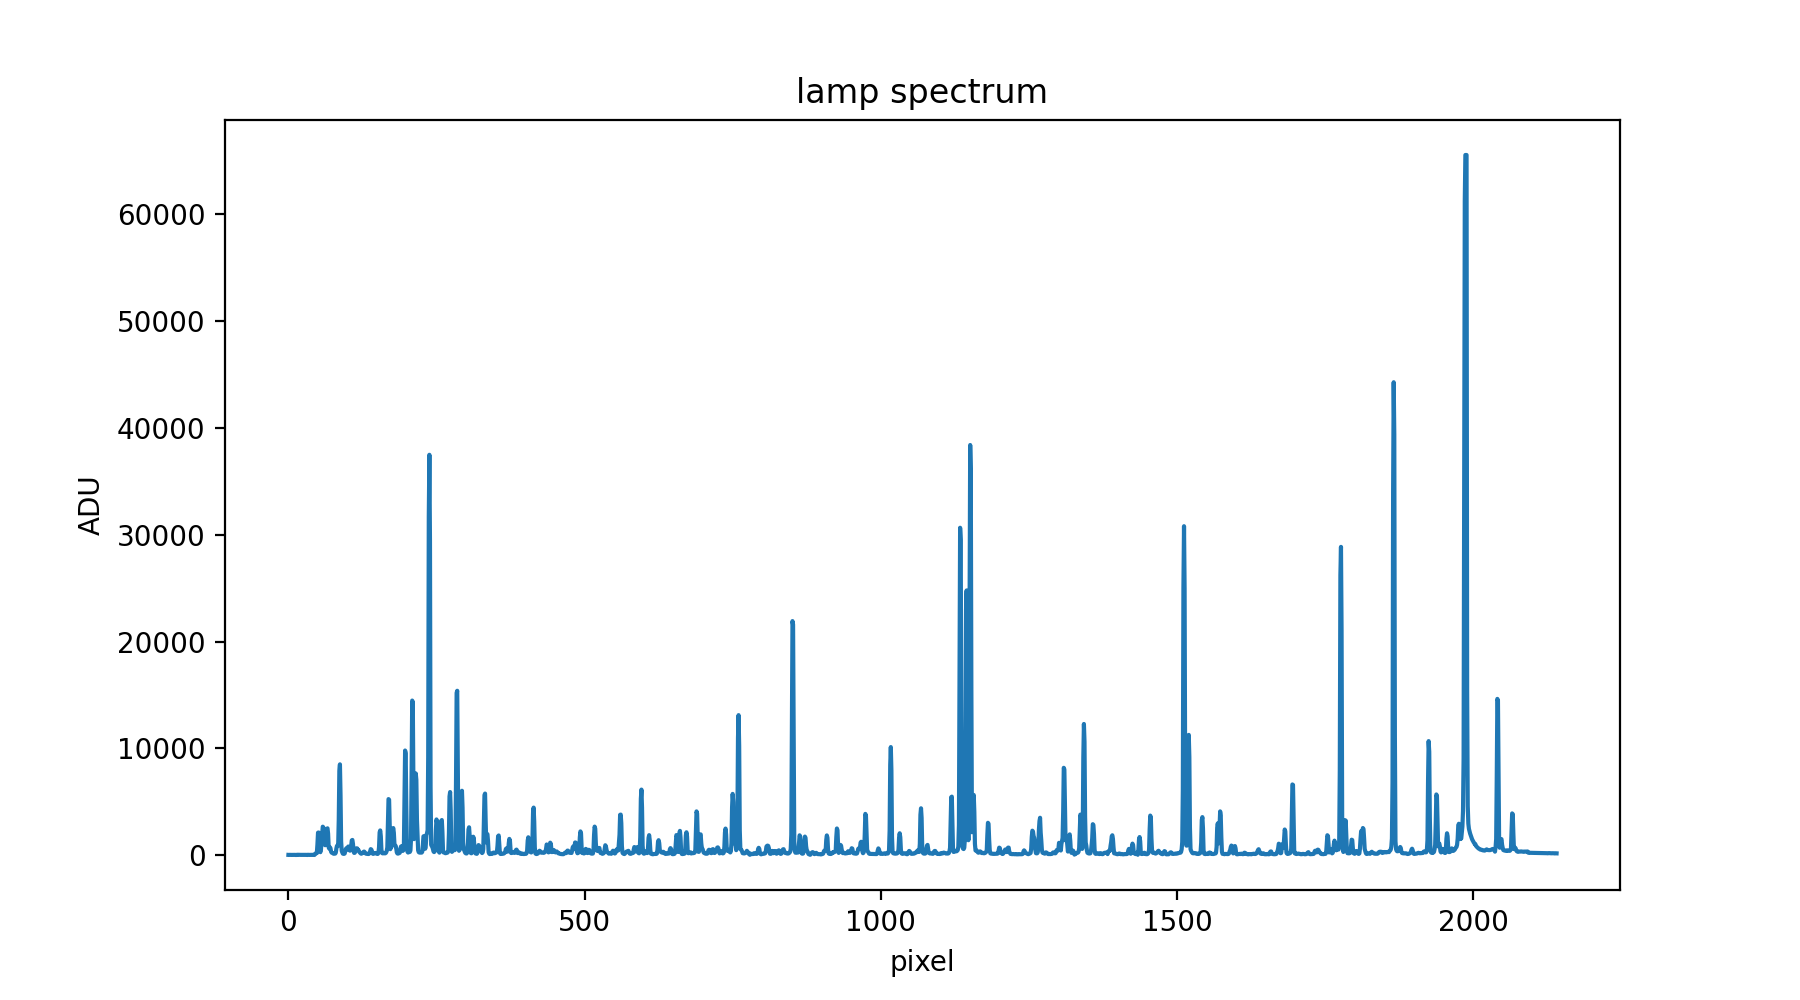

In [2]:
# plot the lamp spectrum
fits_file = '../../data/t152_spectro/lamp_thar/p67507.fits'
xaxis,data=read_raw_spectrum(fits_file)
spectrum=data
plt.figure(figsize=(9,5))
plt.plot(data)
plt.xlabel('pixel')
plt.ylabel('ADU')
plt.title('lamp spectrum')
plt.show()

2142
[  87  169  197  209  215  238  273  285  293  332  596  750  760  851
 1017 1120 1134 1145 1151 1157 1309 1343 1512 1520 1695 1777 1866 1925
 1938 1988 2041]


<IPython.core.display.Javascript object>


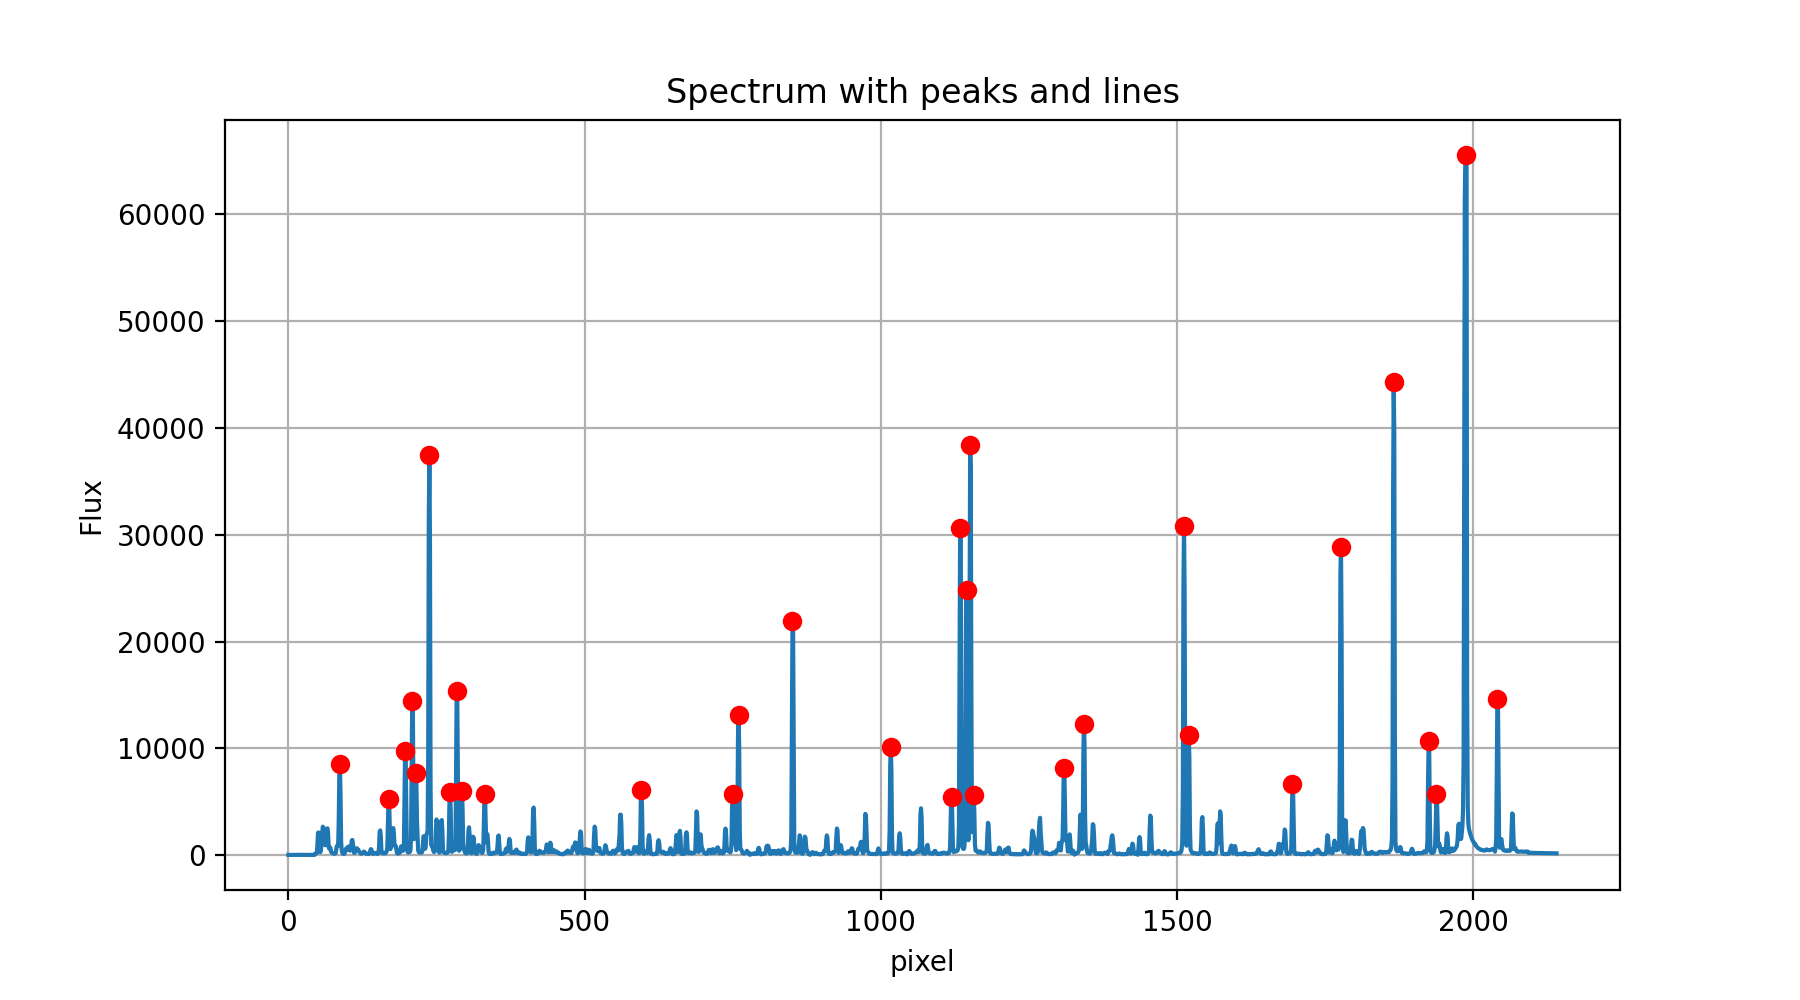

line peak centers
[  87  169  197  209  215  238  273  285  293  332  596  750  760  851
 1017 1120 1134 1145 1151 1157 1309 1343 1512 1520 1695 1777 1866 1925
 1938 1988 2041]


In [3]:
# find peaks in the spectrum
fits_file = '../../data/t152_spectro/lamp_thar/p67507.fits'
xaxis,data=read_raw_spectrum(fits_file)
spectrum=data
print(len(xaxis))
# Find peaks in the spectrum
peaks, _ = find_peaks(data, height=5000.)  # You can adjust the 'height' threshold
# NB: 'fiducial value': height=5000

# Get the centroid (x-value) of each peak
centroid_x_values = peaks
# Positions in pixels of the peaks
print(peaks)

# Plot the spectrum and mark the centroids
plt.figure(figsize=(9, 5))
plt.plot(data)
plt.plot(centroid_x_values, data[peaks], 'ro', label='Max')
plt.xlabel('pixel')
plt.ylabel('Flux')
plt.title('Spectrum with peaks and lines')
plt.grid(True)

# Positions of the peaks in pixels
print('line peak centers')
print(peaks)
# Do you think the peaks positions are representative of the line center?
# What is the precision on the line center?
# is that good enough?


num_peaks 31


<IPython.core.display.Javascript object>


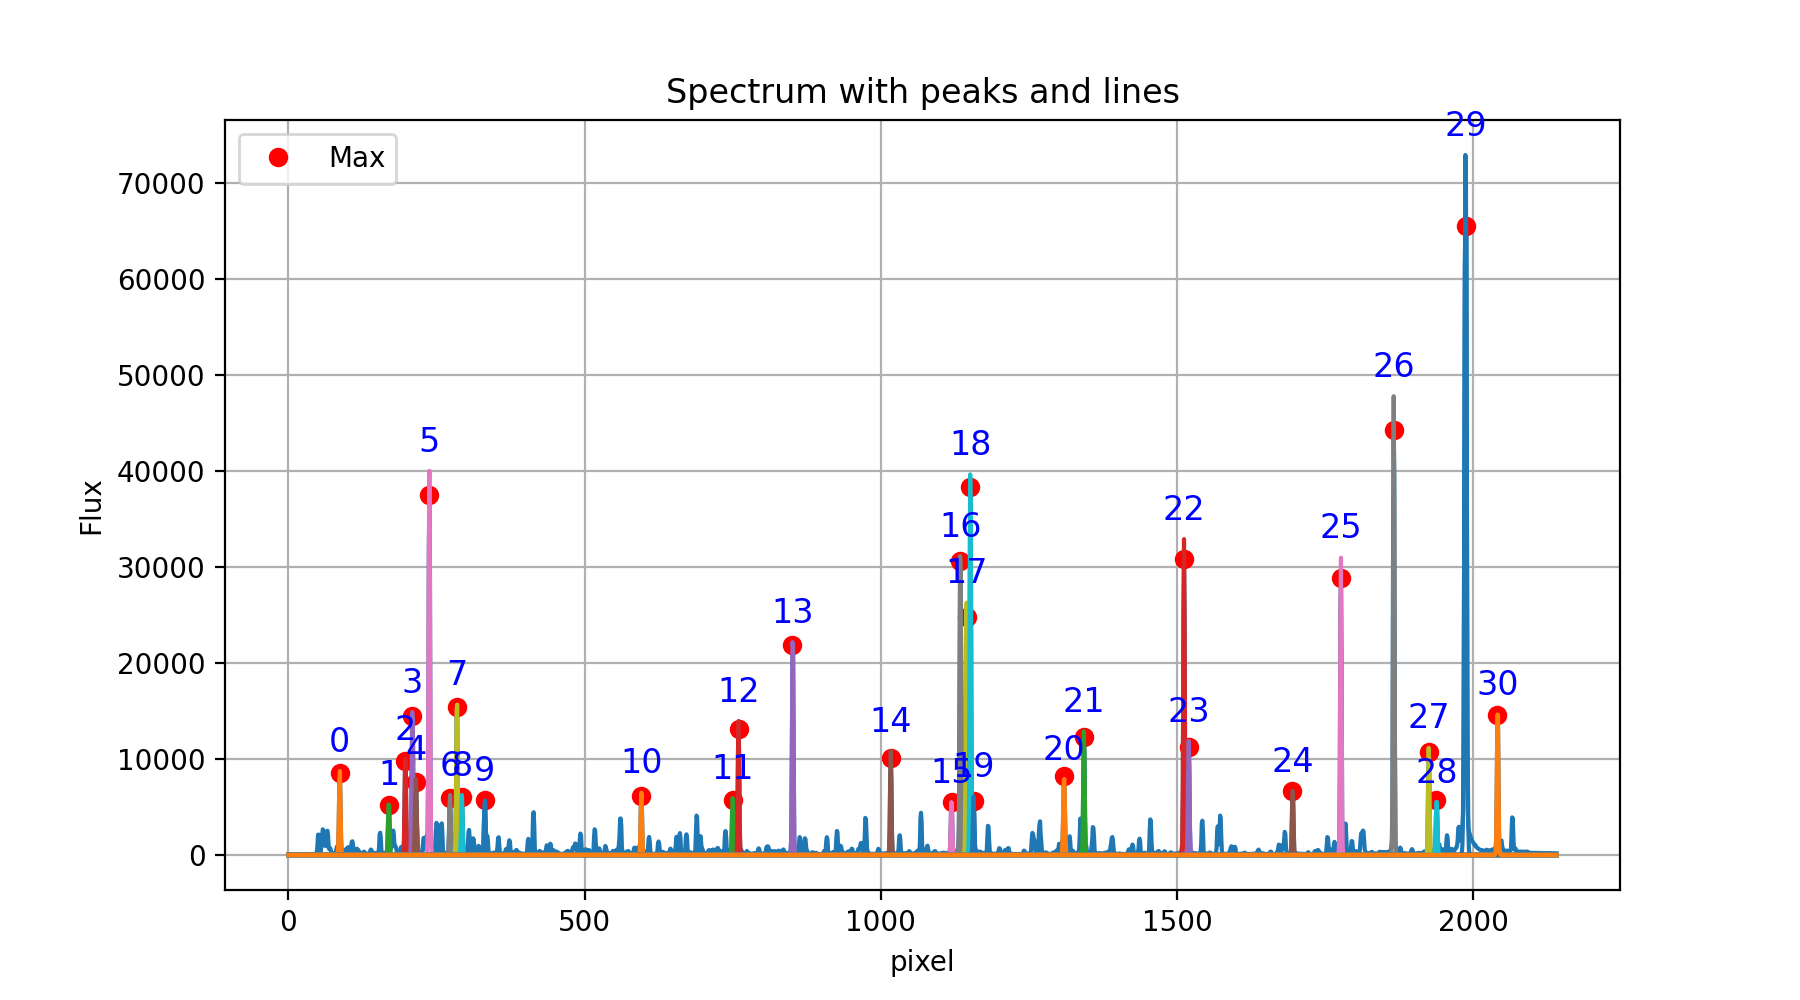

In [4]:
# Nice, now in order to improve the precision on the line centers,
# let's fit each detected peak with a gaussian to get a better centroid position
# generate first_guess for the fitting routine
# The method below just makes up credible values for a triplet (intensity, centre, width) for each line
# (~credible) using the peaks detected 
# and concatenates all that into a large vector first_guess
first_guess=generate_first_guess(peaks)
#print(first_guess)

# fit the lamp spectrum as a sum of gaussian lines using curve_fit and our first guess
params, covariance = curve_fit(gaussian, xaxis, data, p0=first_guess)
#print(np.shape(covariance))
# Reshape params into a 2D array (N, 3) for readability
num_peaks = len(params) // 3
print('num_peaks',num_peaks)
params = np.array(params).reshape((num_peaks, 3))
allamps=params[:,0]
allcens=params[:,1] # => THIS ARRAY HAS THE FITTED GAUSSIAN CENTROILDS OF THE LINES
allwids=params[:,2]

if(0):
    # remove the huge saturaed line at pixel 1987  & 6965 Angstrom
    # well not 100% needed it seems we throw it away later
    print(len(allcens))
    ibad=np.argmin(np.abs(allcens-1987.))
    print(ibad)
    allcens=np.delete(allcens,ibad)
    print(len(allcens))
    allamps=np.delete(allamps,ibad)
    allwids=np.delete(allwids,ibad)
    print(allcens)

    
# Now plot the spectrum again
plt.figure(figsize=(9, 5))
plt.plot(data)
plt.plot(centroid_x_values, data[peaks], 'ro', label='Max')
plt.xlabel('pixel')
plt.ylabel('Flux')
plt.title('Spectrum with peaks and lines')
plt.grid(True)

# plot individual gaussian fit for each line, for check
for i in range(num_peaks):
    fit_params = params[i]  # Extract parameters for each Gaussian
    gau=gaussian(xaxis, *fit_params)
    plt.plot(xaxis, gau)#, label=f'Gaussian {i+1}')
    plt.text(allcens[i], np.max(gau)+3000, str(i), fontsize=12, ha='center', va='center', color='blue')

plt.legend()
plt.show()


<IPython.core.display.Javascript object>


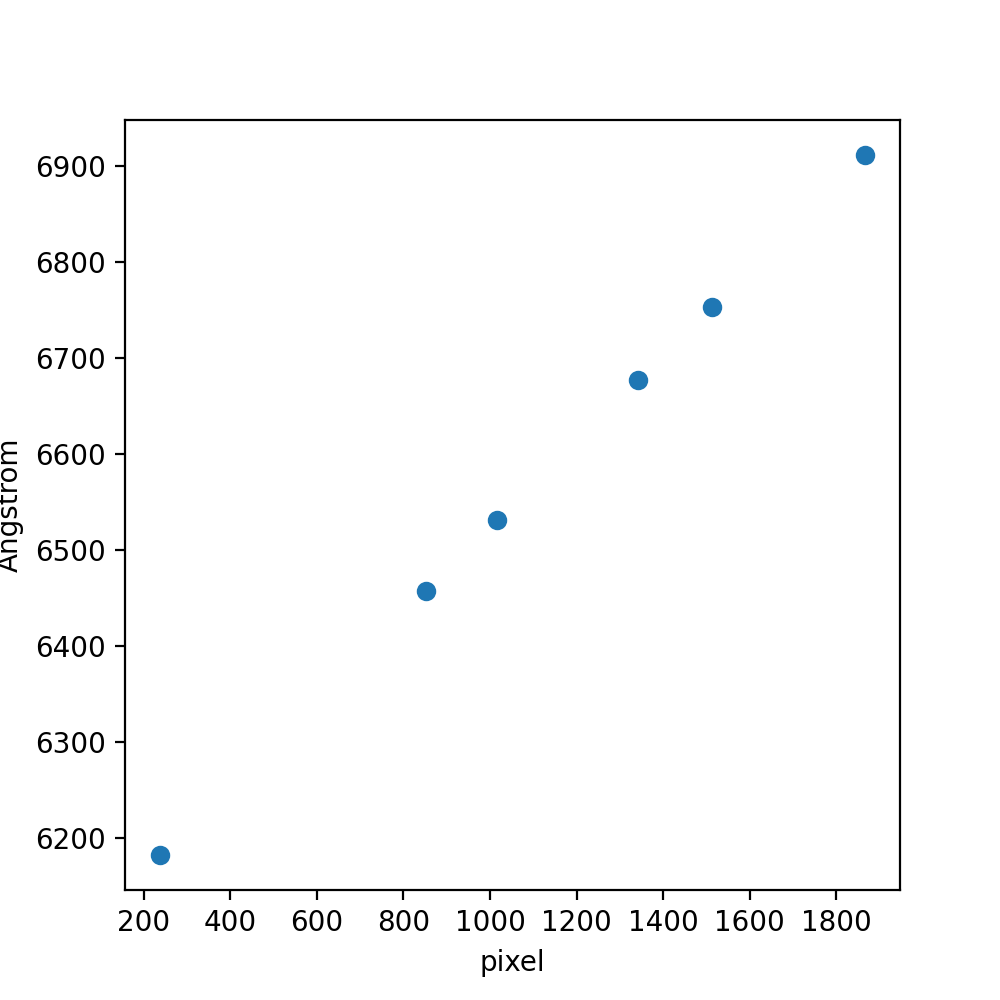

In [5]:
# make your list of at 5-6 lines identified from the atlas
#(https://github.com/pocvirk/astronomical_data_reduction/blob/main/doc/line_atlas_ThAr.pdf)
# the number of lines for our first calibration
npixel_lambda=6
# we build an array (6,2) pixel_lambda where:
# - the first column is the position of a line in pixel
# - the 2nd column is the position of that line in Angstrom in the atlas
pixel_lambda=np.zeros((npixel_lambda,2)) 
# USAGE for guess array: column 1 => position in pixel of the peak, column2 => wavelength from atlas
# the position of the peak is taken from array allcens (gaussian peak centroids computed just before)
pixel_lambda[0]=[allcens[5],6182.62]
pixel_lambda[1]=[allcens[13],6457.28]
pixel_lambda[2]=[allcens[14],6531.34]
pixel_lambda[3]=[allcens[21],6677.28]
pixel_lambda[4]=[allcens[22],6752.83]
pixel_lambda[5]=[allcens[26],6911.23]

plt.figure(figsize=(5,5))
plt.scatter(pixel_lambda[:,0],pixel_lambda[:,1])
plt.xlabel('pixel')
plt.ylabel('Angstrom')
plt.show()

# well our dispersion relation looks almost linear

<IPython.core.display.Javascript object>


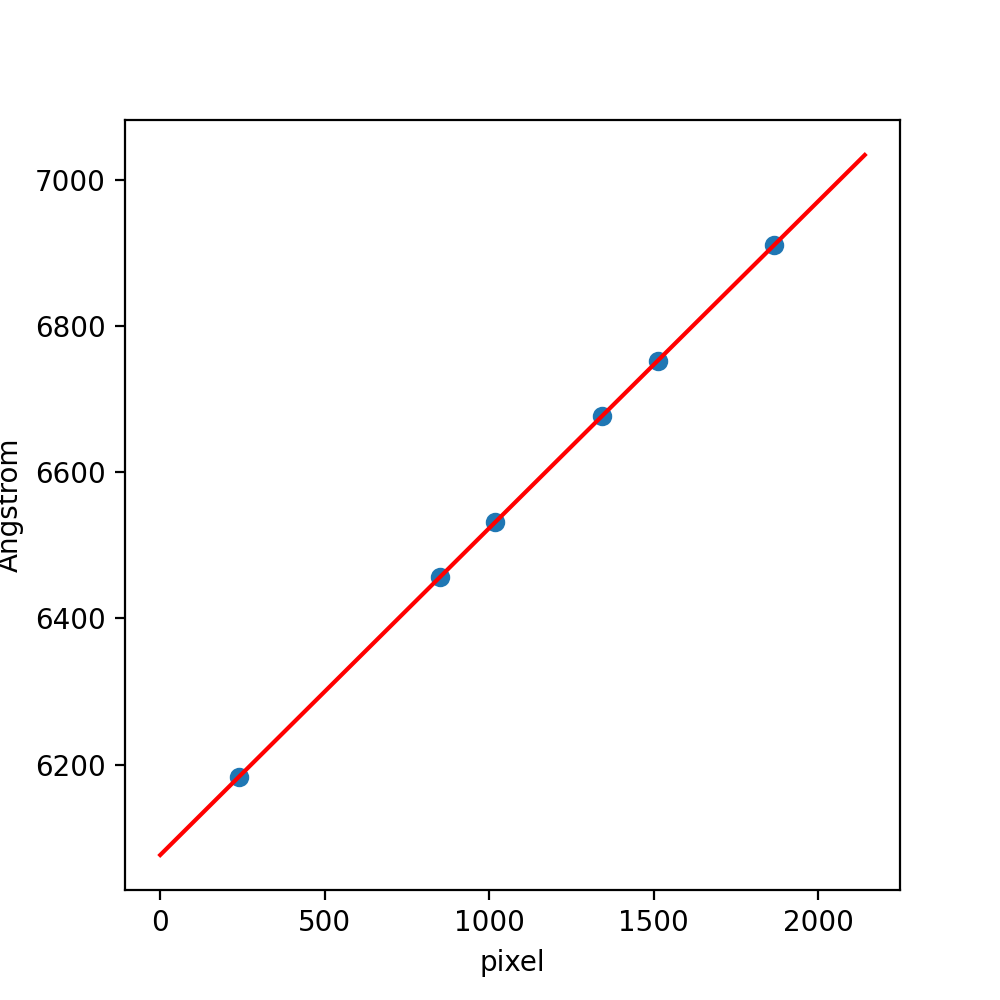

In [6]:
# Now derive the full dispersion law as a polynomial fit through the points above
from numpy.polynomial import chebyshev
# Fit a Chebyshev polynomial of degree 1 (linear)
degree = 1
coeffs = chebyshev.chebfit(pixel_lambda[:,0], pixel_lambda[:,1], degree)
# Evaluate the Chebyshev polynomial across xaxis
y_fit = chebyshev.chebval(xaxis, coeffs)
# plot the fit with our calibration points:
plt.figure(figsize=(5,5))
plt.scatter(pixel_lambda[:,0],pixel_lambda[:,1])
plt.xlabel('pixel')
plt.ylabel('Angstrom')
plt.plot(xaxis, y_fit, label=f'Chebyshev Polynomial (Degree {degree})', color='red')
plt.show()

# thats a pretty good fit.
# to see how good it is, we will check the residuals in the next cell

<IPython.core.display.Javascript object>


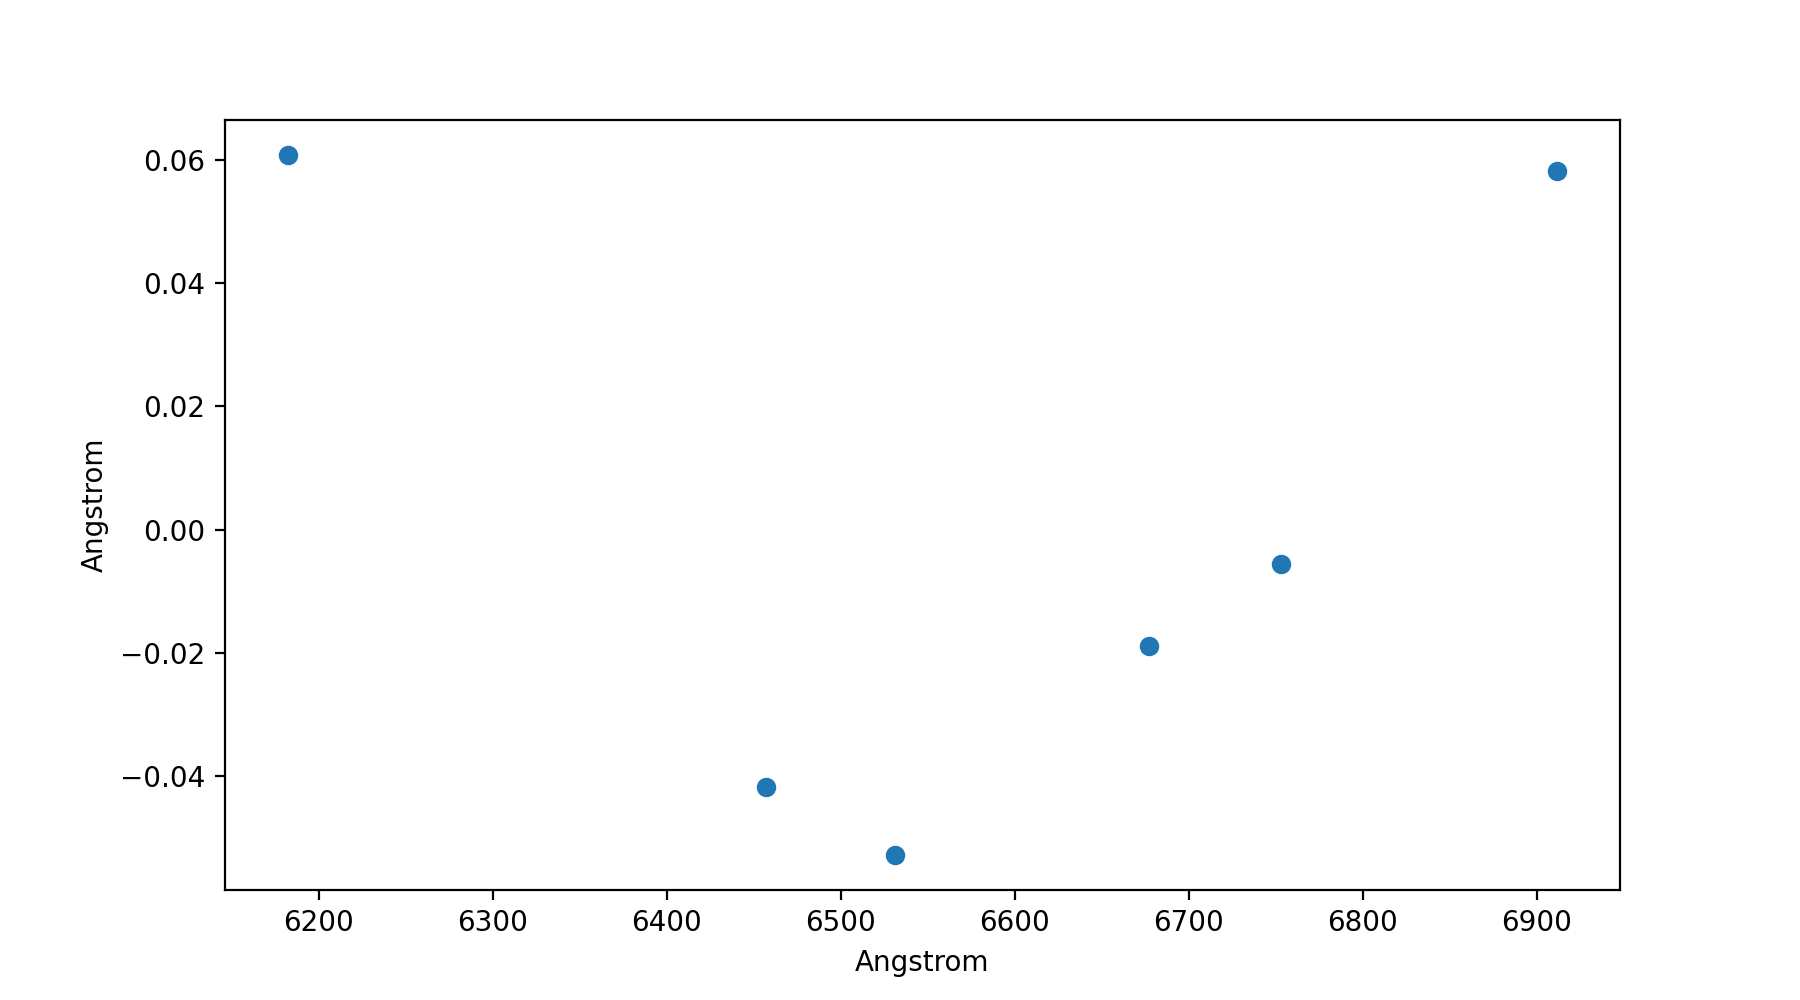

RESIDUALS INITIAL set of lines
NLINES= 6
RESIDUALS AVG 4.547473508864641e-13  Angstrom
RESIDUALS RMS 0.044670894989369256 Angstrom
RESIDUALS RMS 2.03498761611782 km/s


In [7]:
#Residuals are the difference between the predicted value by the polynomial and the actual position 
# of the points in the cloud of points we are trying to fit.
import numpy as np
npoints=len(pixel_lambda[:,1])
predicted_wl=chebyshev.chebval(pixel_lambda[:,0],coeffs)
atlas_wl=pixel_lambda[:,1]
residuals = predicted_wl-atlas_wl

residuals_first_iter=residuals # save for later reference and comparison
atlas_wl_first_iter=atlas_wl # save for later reference and comparison

plt.figure(figsize=(9,5))
plt.scatter(atlas_wl,residuals)
plt.xlabel('Angstrom')
plt.ylabel('Angstrom')
plt.show()

# display some stats about the residuals:
print('==============================')
print('RESIDUALS INITIAL set of lines')
print('NLINES=',len(pixel_lambda[:,1]))
print('RESIDUALS AVG',np.average(residuals),' Angstrom')
print('RESIDUALS RMS',np.std(residuals), 'Angstrom')
print('RESIDUALS RMS',np.std(residuals)/np.average(atlas_wl)*3.e5,'km/s')
print('==============================')

# Do you notice anything particular in the distribution of the residuals?

# ok not bad but it has only 6 points.
# how can we add more calibration points now that we have this first idea of what the dispersion relation
# should be?

./linelists/ThI.csv Number of lines  1376


<IPython.core.display.Javascript object>


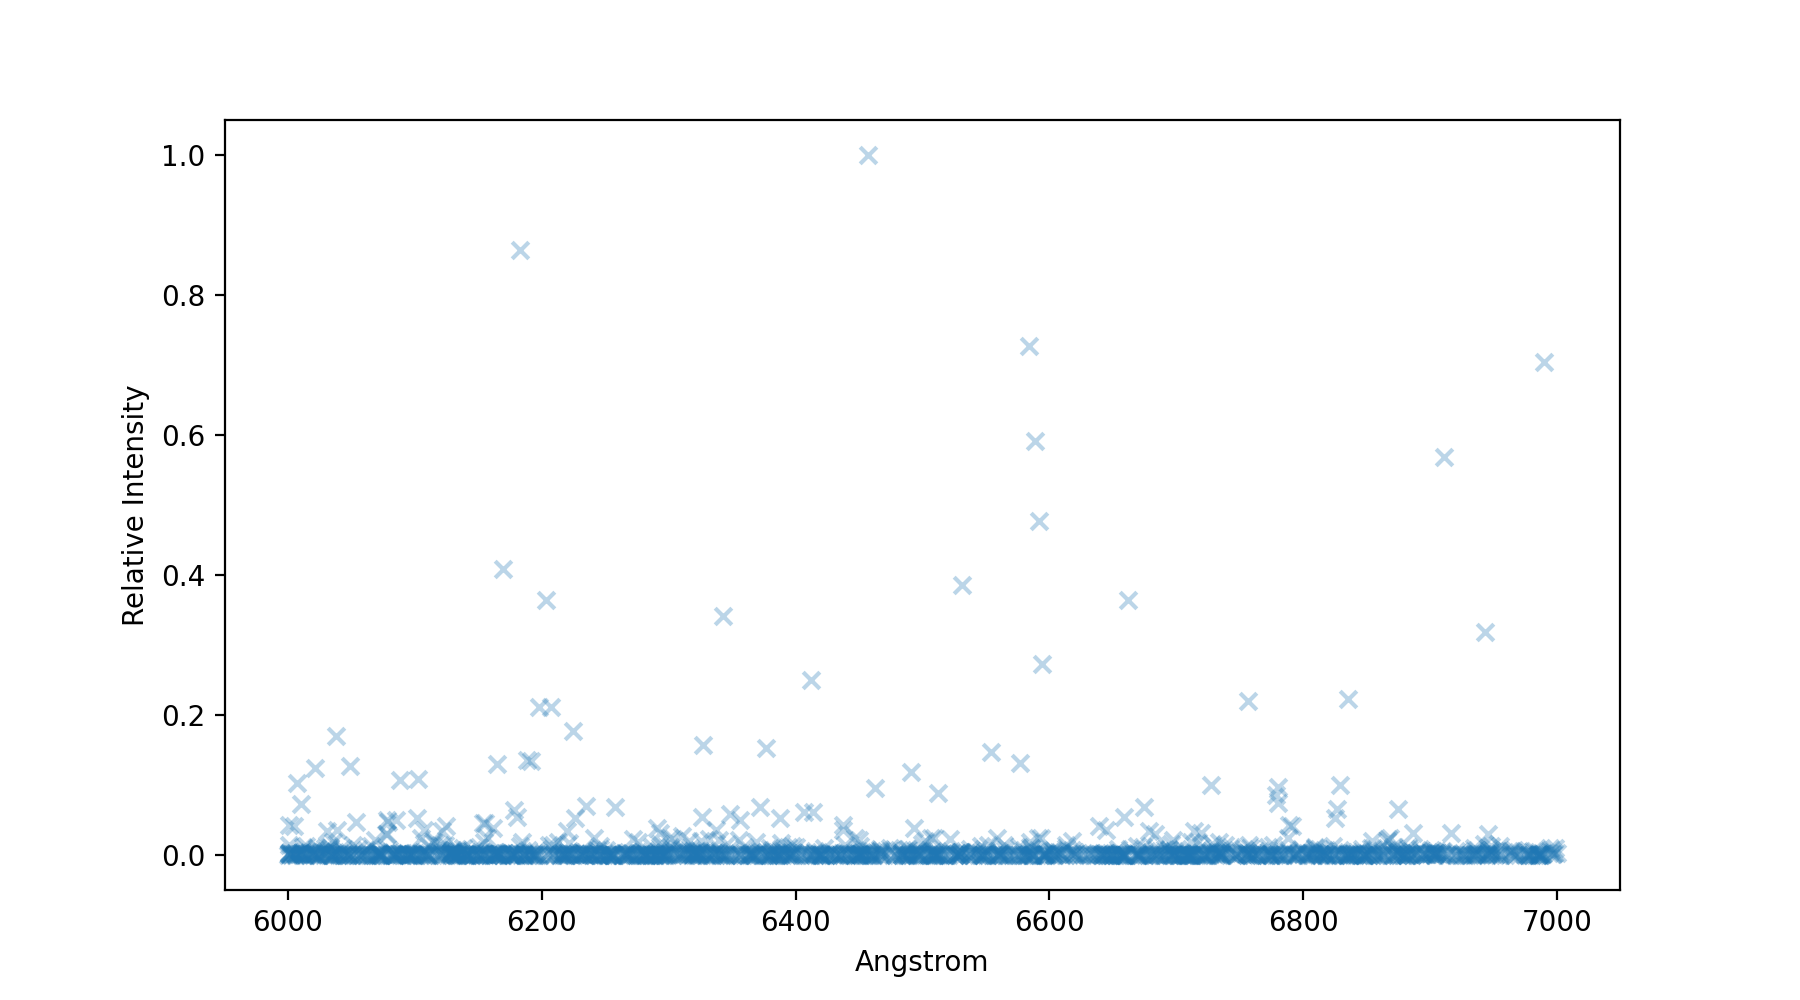

In [8]:
# Now to refine our first guess of the dispersion relation, 
# we will try to match (some of) the other lines of our lamp spectrum
# to lines from the NIST lines atlas (super accurate laboratory line list)
# first read the NIST line list
file_path = './linelists/ThI.csv'
# Load the data from the CSV file
dataThI = np.loadtxt(file_path, delimiter=',', skiprows=1)  # Skip the header row
print(file_path,'Number of lines ',len(dataThI))
data=dataThI
# Split the data into 'wls' and 'rels' arrays
NIST_wls = data[:, 0]  # Assumes wavelength is in the first column
NIST_rels = data[:, 1]  # Assumes intensity is in the second column
NIST_rels=NIST_rels/np.max(NIST_rels) # normalize by the max intensity for convenience

# just have a look at this linelist:
plt.figure(figsize=(9,5))
plt.scatter(NIST_wls,NIST_rels,marker='x',alpha=0.3)
plt.xlabel('Angstrom')
plt.ylabel('Relative Intensity')
plt.show()

Number of NIST lines kept 19


<IPython.core.display.Javascript object>


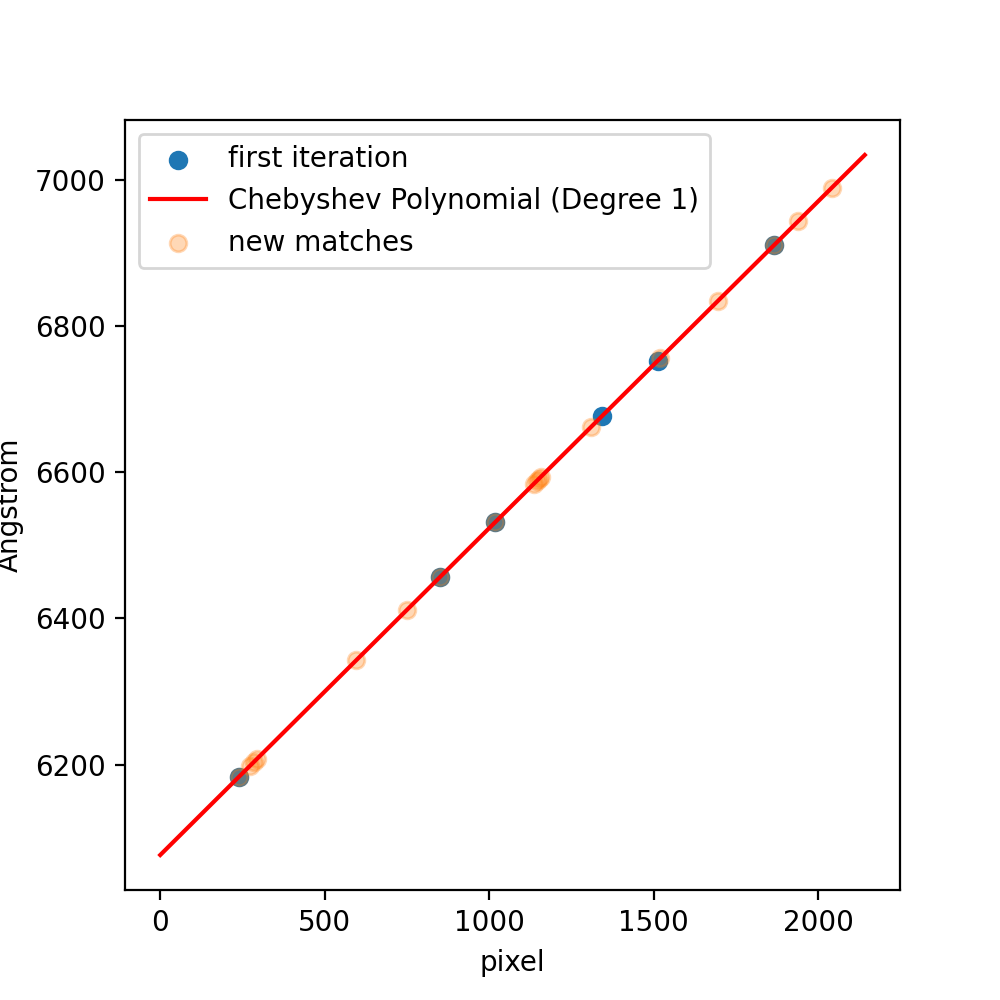

In [9]:
# thats a lot of faint lines!
# select only the brightest of lines from the NIST linelist
ind=np.where(NIST_rels>=0.2)[0]
NIST_wls=NIST_wls[ind]
NIST_rels=NIST_rels[ind]
print('Number of NIST lines kept',len(ind))

# prepare tables, the size of the number of peaks we kept from the lamp (num_peaks)
match = np.zeros(num_peaks) # the match vector: 0 means there is no match for that line
predicted_wl=np.zeros(num_peaks) # wavelength predicted by our polynomial calibration
atlas_wl=np.zeros(num_peaks)     # wavelength of the match in the atlas
residuals = np.zeros(num_peaks)

# Max delta allowed for a match
maxdelta=0.2 # Angstrom 

# Check if in our lamp lines, there can be a match in the NIST line list
for i in range(num_peaks):
    predicted_wl[i]=chebyshev.chebval(allcens[i],coeffs) # predicted wavelength for lamp line
    imin=np.argmin(np.abs(predicted_wl[i]-NIST_wls)) # index of the closest line in the NIST atlas line list
    residuals[i]=(predicted_wl[i]-NIST_wls[imin]) # distance (Angstrom) between the closest NIST line and our lamp line
    atlas_wl[i]=NIST_wls[imin] # NIST wavelength for that line
    if(np.abs(residuals[i])<maxdelta): # we keep that match only if the difference in angstrom < maxdelta
        match[i]=imin

# plot the new matched lines on top of the lines we had before:
plt.figure(figsize=(5,5))
plt.scatter(pixel_lambda[:,0],pixel_lambda[:,1],label='first iteration')
plt.xlabel('pixel')
plt.ylabel('Angstrom')
plt.plot(xaxis, y_fit, label=f'Chebyshev Polynomial (Degree {degree})', color='red')
ind=np.where(match!=0)[0] # select only matches
plt.scatter(allcens[ind],atlas_wl[ind],alpha=0.3,label='new matches')

plt.legend()
plt.show()

# this looks nice but is it any good?
# to gain insight, lets look at the residuals

<IPython.core.display.Javascript object>


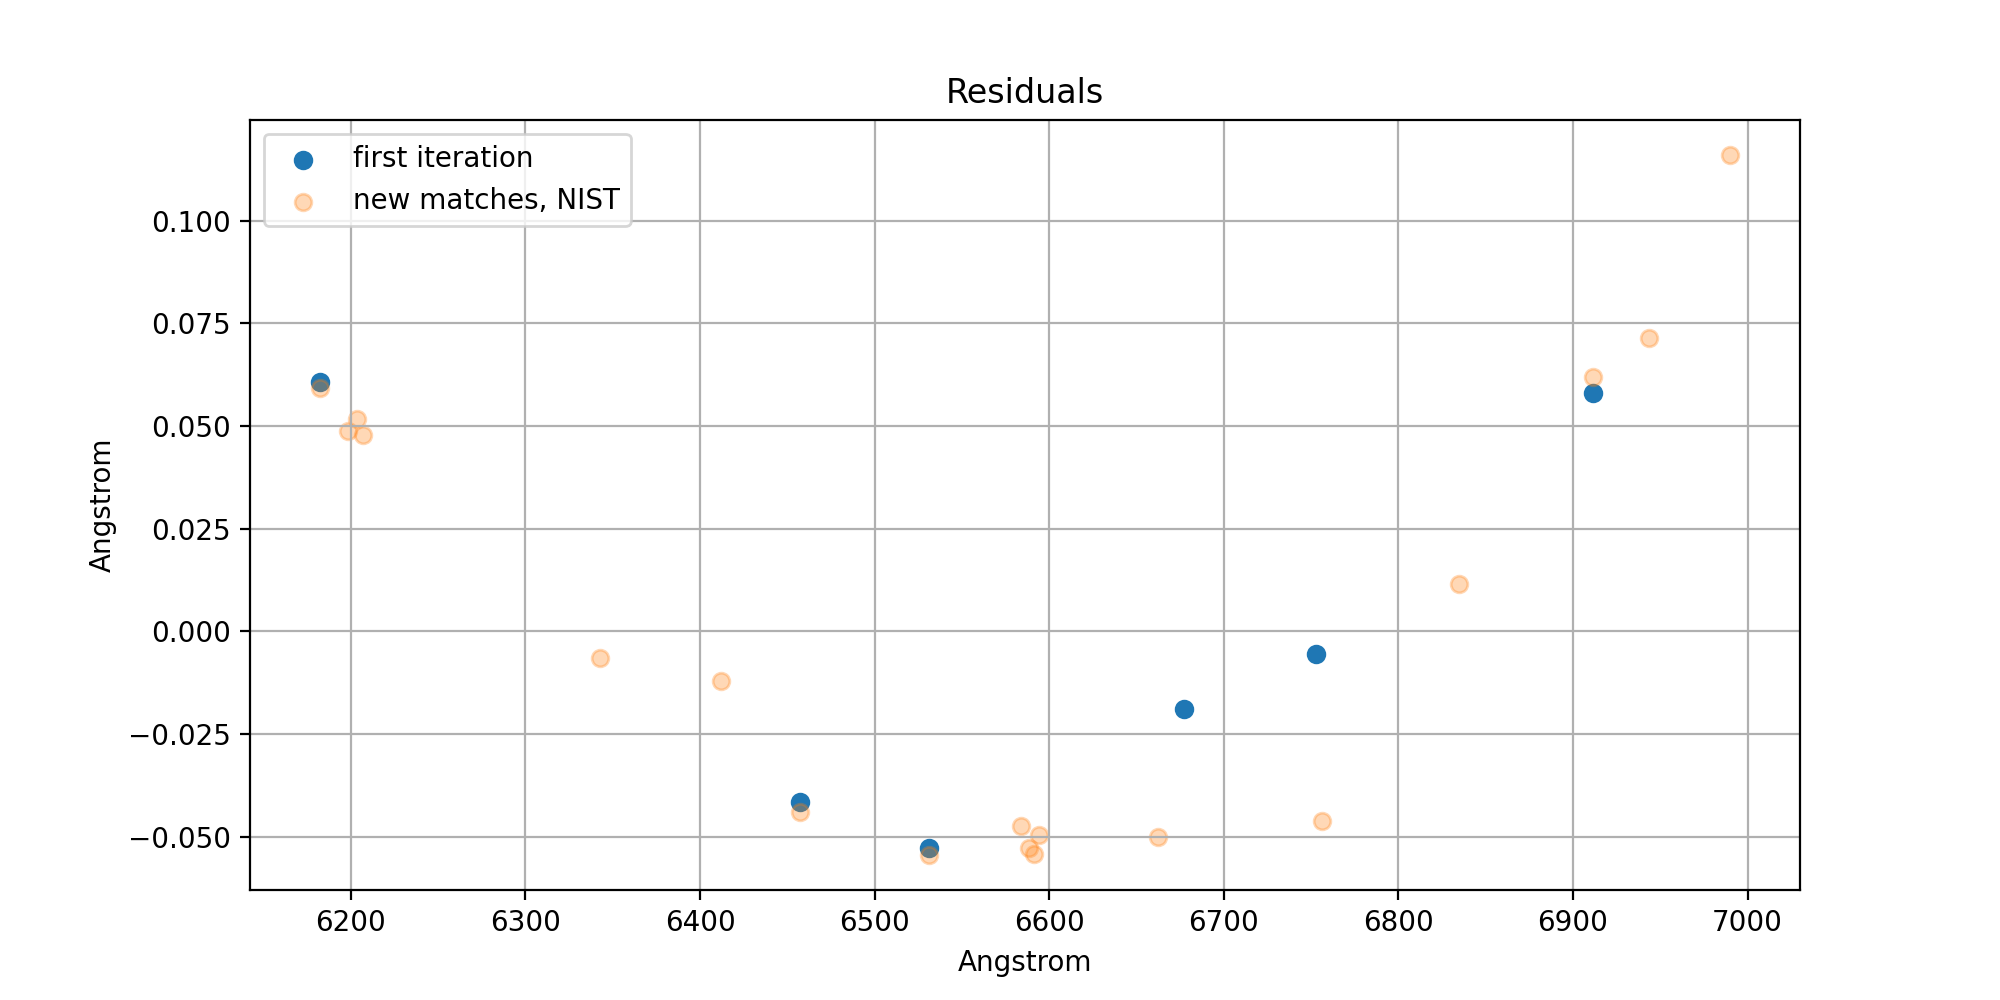

RESIDUALS INITIAL set of lines
NLINES= 6
RESIDUALS AVG 4.547473508864641e-13
RESIDUALS RMS 0.044670894989369256
RESIDUALS RMS 2.03498761611782 km/s
RESIDUALS NEW set of lines
NLINES= 18
RESIDUALS AVG 0.0028399079021457713
RESIDUALS RMS 0.05447132306180852
RESIDUALS RMS 2.492946759476481 km/s


In [10]:
# lets look at the residuals
plt.figure(figsize=(10,5))
plt.scatter(atlas_wl_first_iter,residuals_first_iter,label='first iteration')
ind=np.where(match!=0)[0]
plt.scatter(atlas_wl[ind],residuals[ind],alpha=0.3,label='new matches, NIST')
plt.grid()
plt.legend()
plt.title('Residuals')
plt.xlabel('Angstrom')
plt.ylabel('Angstrom')
plt.show()
print('==============================')
print('RESIDUALS INITIAL set of lines')
print('NLINES=',len(pixel_lambda[:,1]))
print('RESIDUALS AVG',np.average(residuals_first_iter))
print('RESIDUALS RMS',np.std(residuals_first_iter))
print('RESIDUALS RMS',(np.std(residuals_first_iter)/np.average(atlas_wl_first_iter)*3.e5),'km/s')
print('==============================')
print('RESIDUALS NEW set of lines')
print('NLINES=',len(ind))
print('RESIDUALS AVG',np.average(residuals[ind]))
print('RESIDUALS RMS',np.std(residuals[ind]))
print('RESIDUALS RMS',(np.std(residuals[ind])/np.average(atlas_wl[ind]))*3.e5,'km/s')
print('===============================')

[ 6.07606805e+03  4.47859767e-01 -8.49266308e-08]


<IPython.core.display.Javascript object>


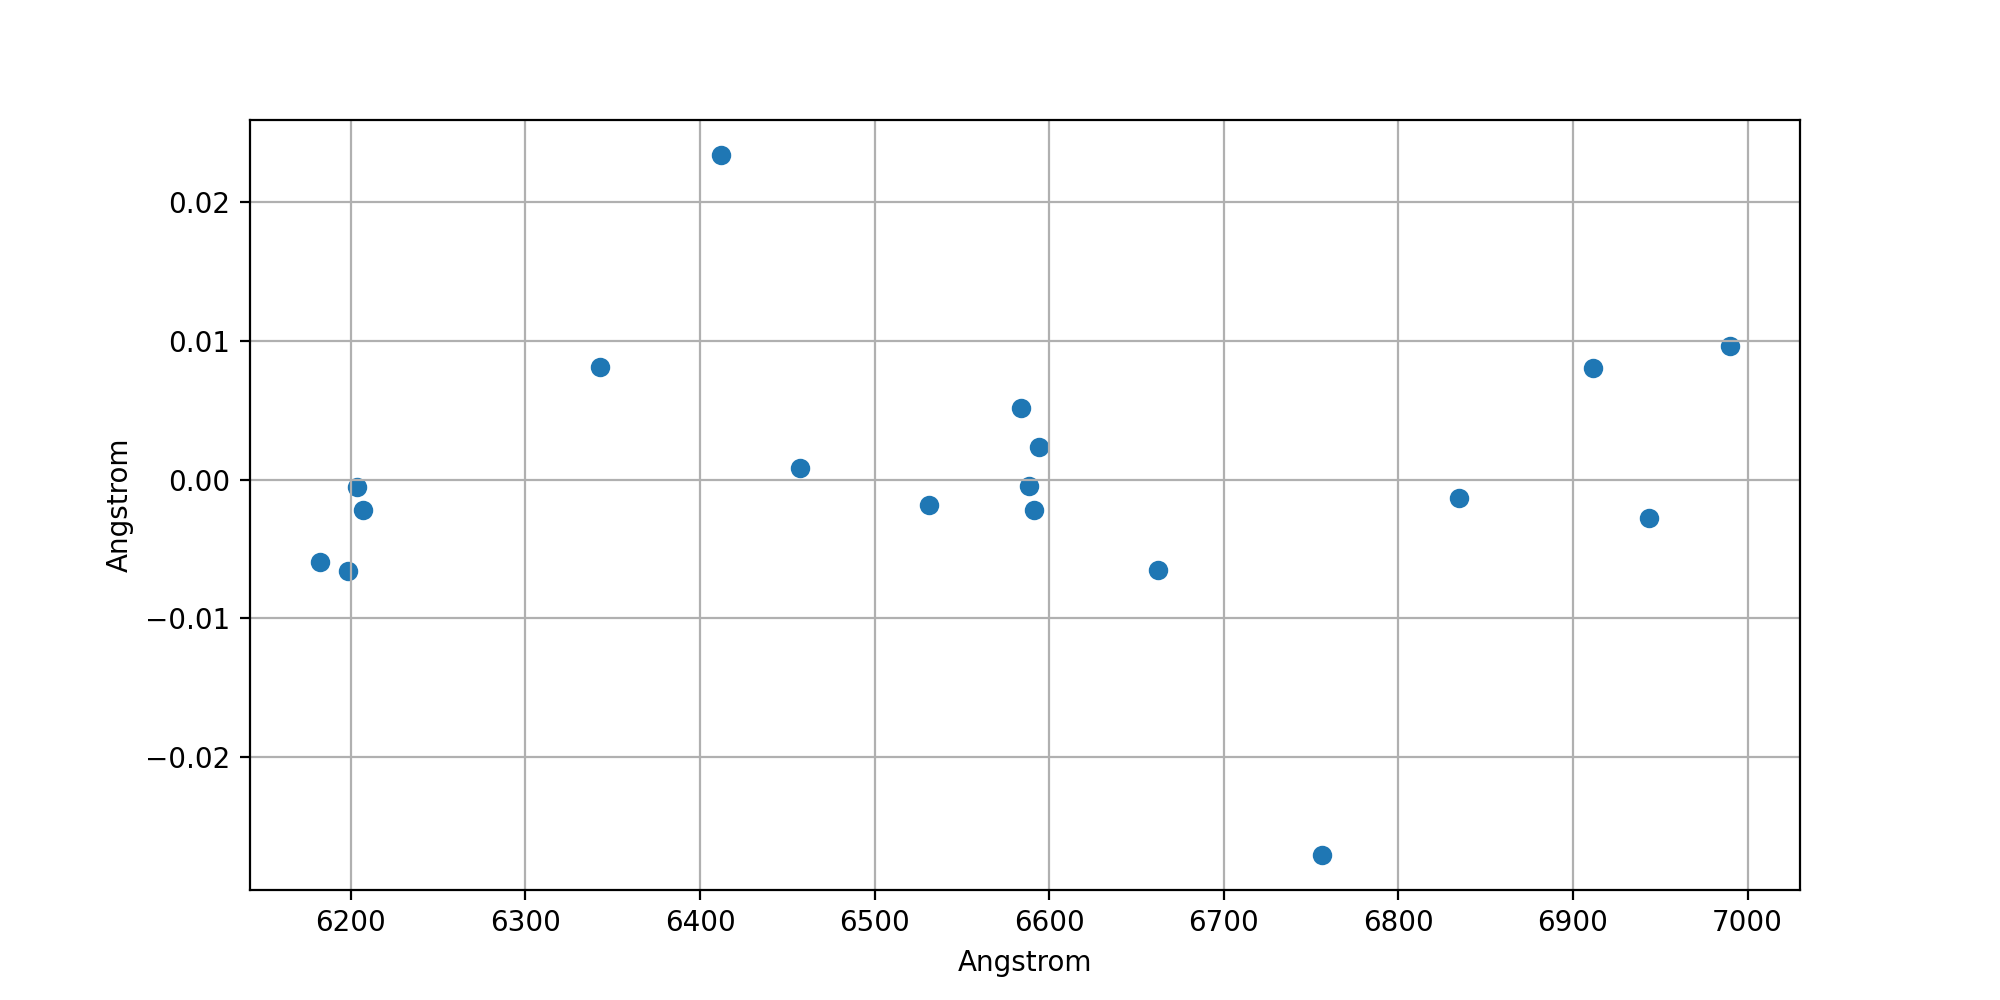

RESIDUALS NEW set of lines
NLINES= 18
DEGREE= 2
RESIDUALS AVG 2.5263741715914674e-13
RESIDUALS RMS 0.009668567212435678
RESIDUALS RMS 0.4424938104343857 km/s


In [11]:
# now try that again now that we have these new additional lines
new_pixel_lambda=np.zeros((len(ind),2))
new_pixel_lambda[:,0]=allcens[ind]
new_pixel_lambda[:,1]=atlas_wl[ind]
pixel_lambda=new_pixel_lambda

degree=2
coeffs = chebyshev.chebfit(pixel_lambda[:,0], pixel_lambda[:,1], degree)
print(coeffs)
# Evaluate the Chebyshev polynomial at the x_range
y_fit = chebyshev.chebval(xaxis, coeffs)
predicted=chebyshev.chebval(pixel_lambda[:,0], coeffs)
plt.figure(figsize=(10,5))
residuals=predicted-new_pixel_lambda[:,1]
plt.scatter(pixel_lambda[:,1],residuals,label='second iteration')
plt.ylabel('Angstrom')
plt.xlabel('Angstrom')
plt.grid()
plt.show()
print('==============================')
print('RESIDUALS NEW set of lines')
print('NLINES=',len(ind))
print('DEGREE=',degree)
print('RESIDUALS AVG',np.average(residuals))
print('RESIDUALS RMS',np.std(residuals))
print('RESIDUALS RMS',(np.std(residuals))/np.average(pixel_lambda[:,1])*3.e5,'km/s')
print('==============================')


In [12]:
# So our FINAL calibration result is the line below: 
# We can build the full wavelengths axis of our observed spectra by evaluating the polynomial
wavelengths=chebyshev.chebval(xaxis, coeffs)
# and save it to a file to retrieve later for spectral analysis:
calib_file='../../data/t152_spectro/lamp_thar/calib/calib.dat'
wavelengths.tofile(calib_file)
# NB: here we are not storing the coeffs of the polynomial but the whole 2142 array representing
# the wavelengths in Angstrom

<IPython.core.display.Javascript object>


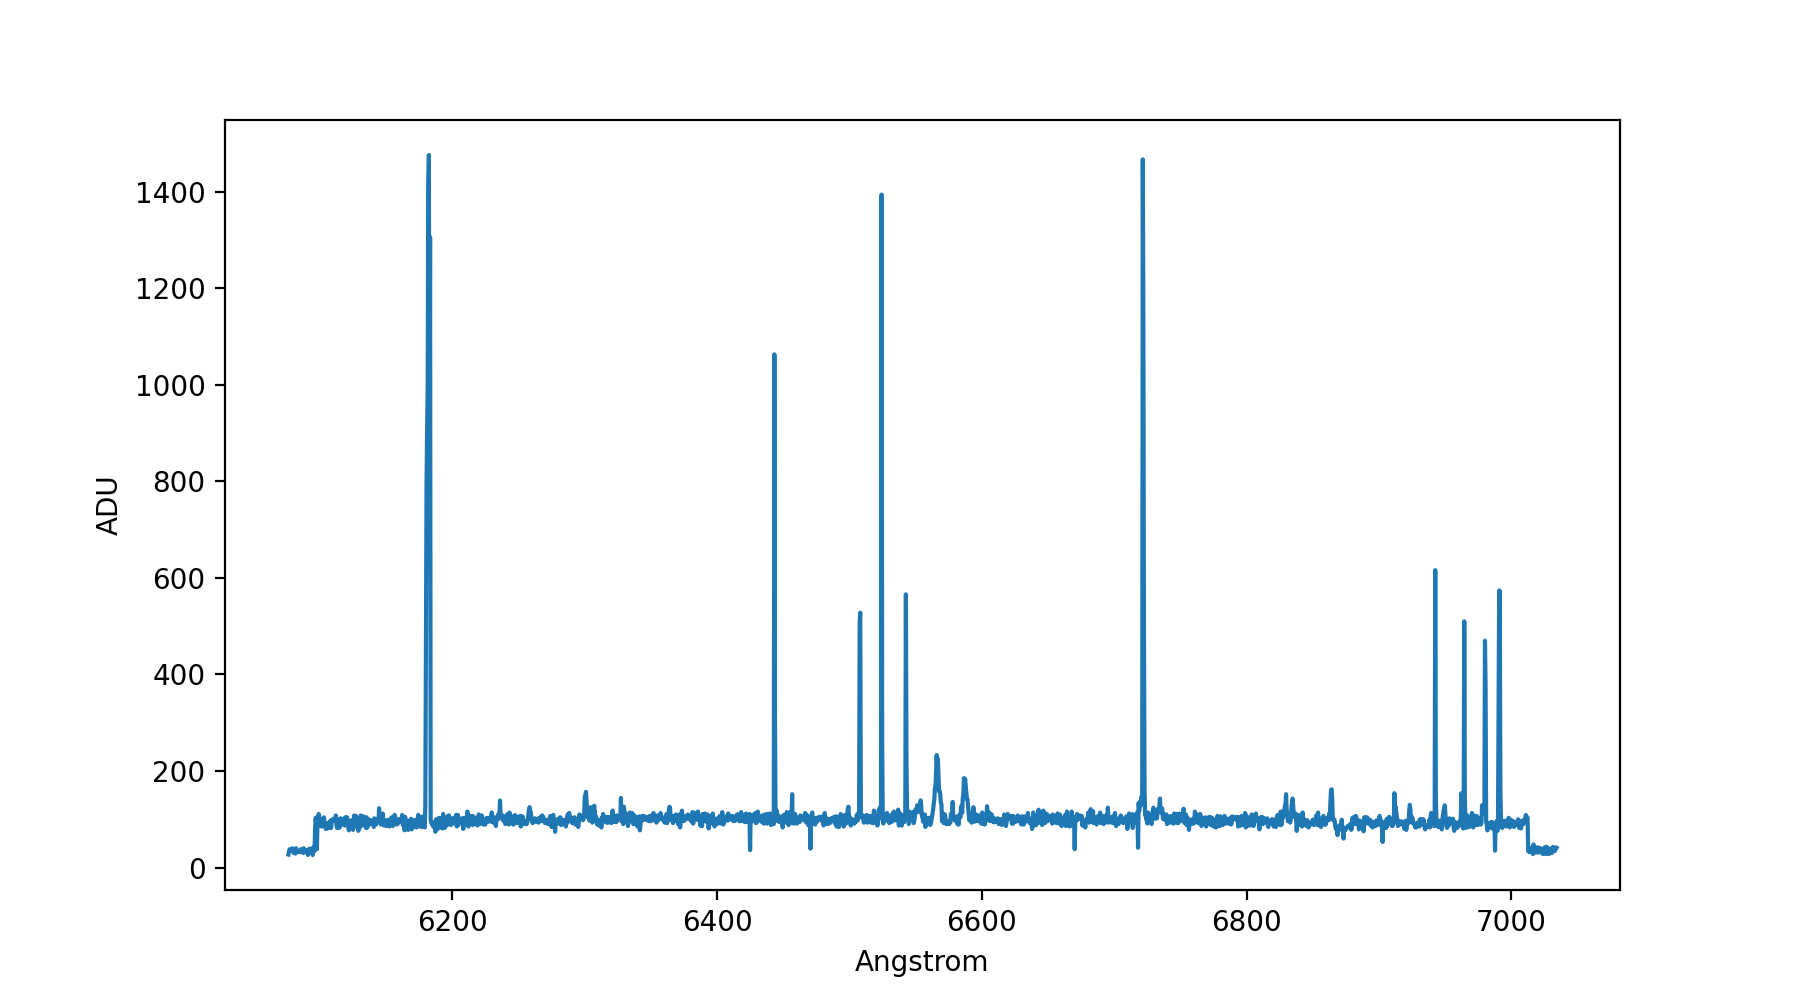

SIMPLE  =                    T /                                                
BITPIX  =                   32 /                                                
NAXIS   =                    2 /                                                
NAXIS1  =                 2142 /                                                
NAXIS2  =                    1 /                                                
DATE    ='2007-02-20'          /                                                
DATE-OBS='2007-02-20'          /                                                
OBJECT  ='M82ouest           ' /                                                
TM-START=                 9527 /                                                
TM-EXPOS=                  720 /                                                
J_D     =        2454151.61027 /                                                
POSTN-RA=             148.9661 /                                                
POSTN-DE=              69.68

In [13]:
# we can retrieve the wavelengths axis like this:
wavelengths=np.fromfile(calib_file)
# With this wavelength axis, I can finally plot any observed spectrum with a physical wavelenth axis:
file='../../data/t152_spectro/M82/p67532.fits'
xaxis,data,header=read_raw_spectrum(file,get_header=1)
plt.figure(figsize=(9,5))
# we can now replace the x axis with our wavelengths
plt.plot(wavelengths,data)
plt.ylabel('ADU')
plt.xlabel('Angstrom')
plt.show()

print(repr(header))

[200.0, 6566, 2.0]
[1.90317731e+02 6.56606216e+03 3.82194214e+00]


<IPython.core.display.Javascript object>


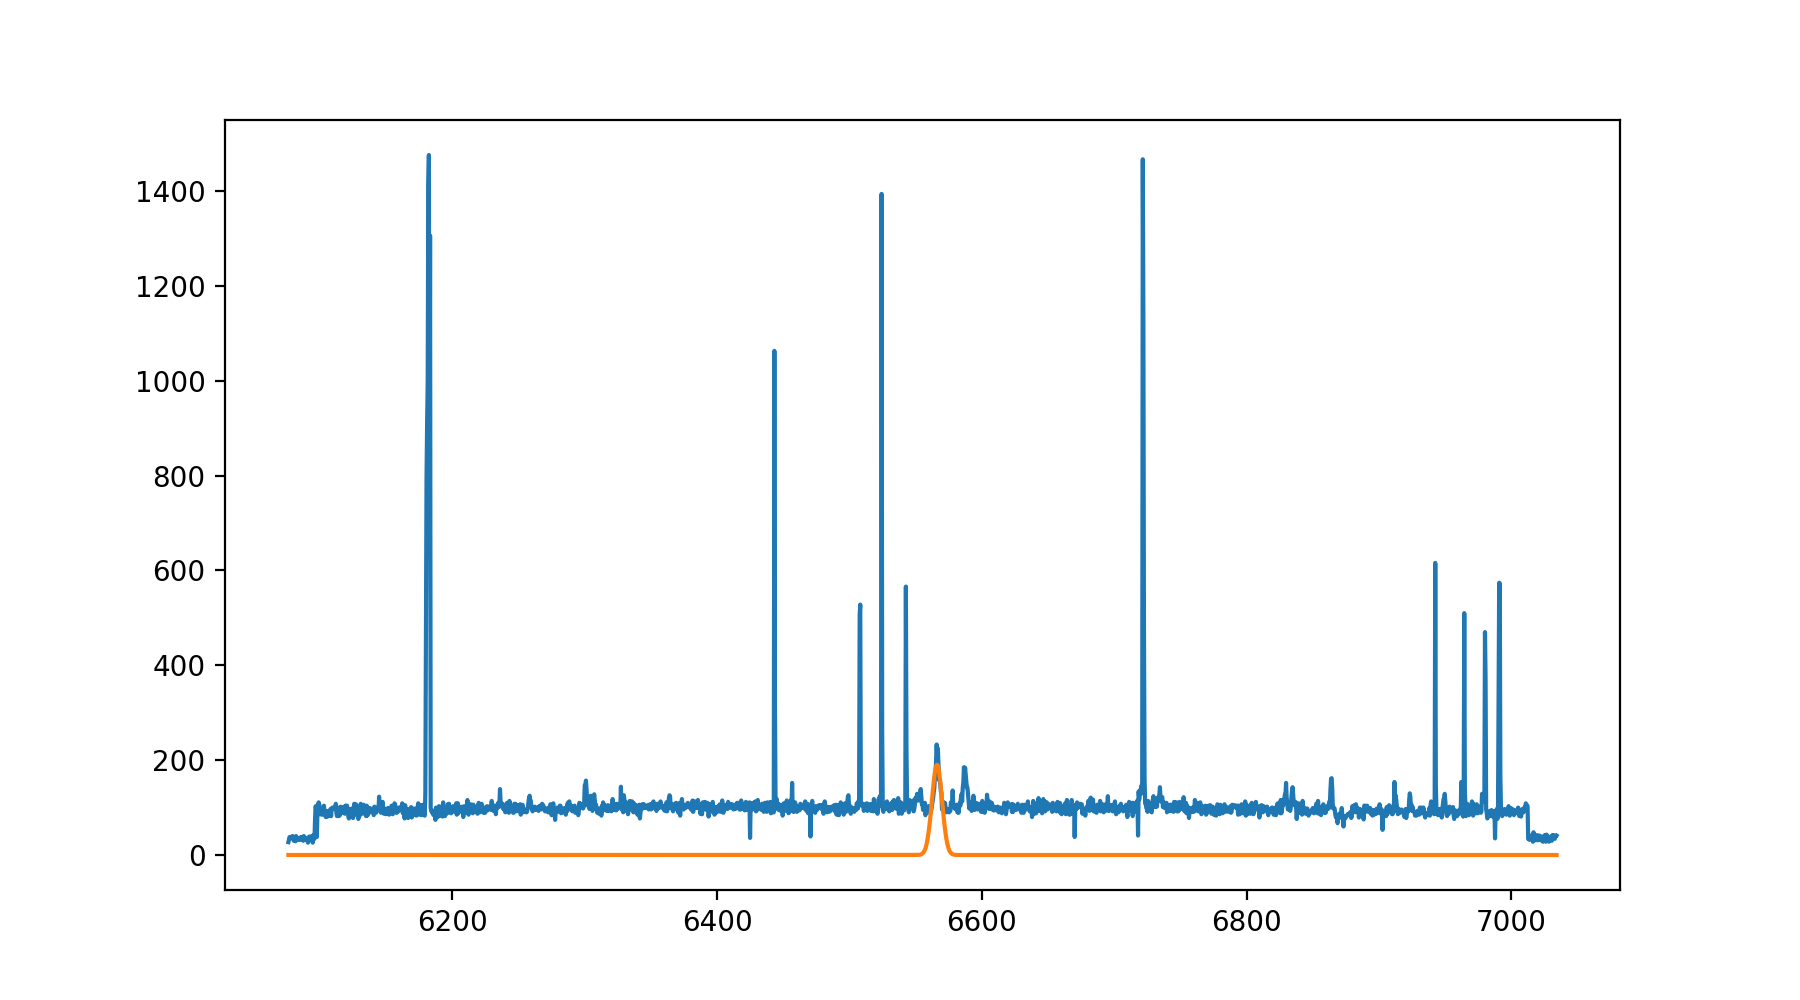

[1.90317731e+02 6.56606216e+03 3.82194214e+00]


In [14]:
ha_guess=[200.,6566,2.]
print(ha_guess)

sigma=wavelengths*0.+1.e10
ind=np.where((wavelengths>=6560.)&(wavelengths<=6570.))[0]
sigma[ind]=1.e-5
# fit the lamp spectrum as a sum of gaussian lines using curve_fit and our first guess
params, covariance = curve_fit(gaussian, wavelengths, data, p0=ha_guess,sigma=sigma)
print(params)
gau=gaussian(wavelengths, *params)

plt.figure(figsize=(9,5))
plt.plot(wavelengths,data)
plt.plot(wavelengths,gau)

plt.show()

print(params)

if(0):
    #print(np.shape(covariance))
    # Reshape params into a 2D array (N, 3) for readability
    num_peaks = len(params) // 3
    print('num_peaks',num_peaks)
    params = np.array(params).reshape((num_peaks, 3))
    allamps=params[:,0]
    allcens=params[:,1] # => THIS ARRAY HAS THE FITTED GAUSSIAN CENTROILDS OF THE LINES
    allwids=params[:,2]




[200.0, 6566, 2.0, 100.0]
[1.19441356e+02 6.56624828e+03 1.69507743e+00 9.44932191e+01]


<IPython.core.display.Javascript object>


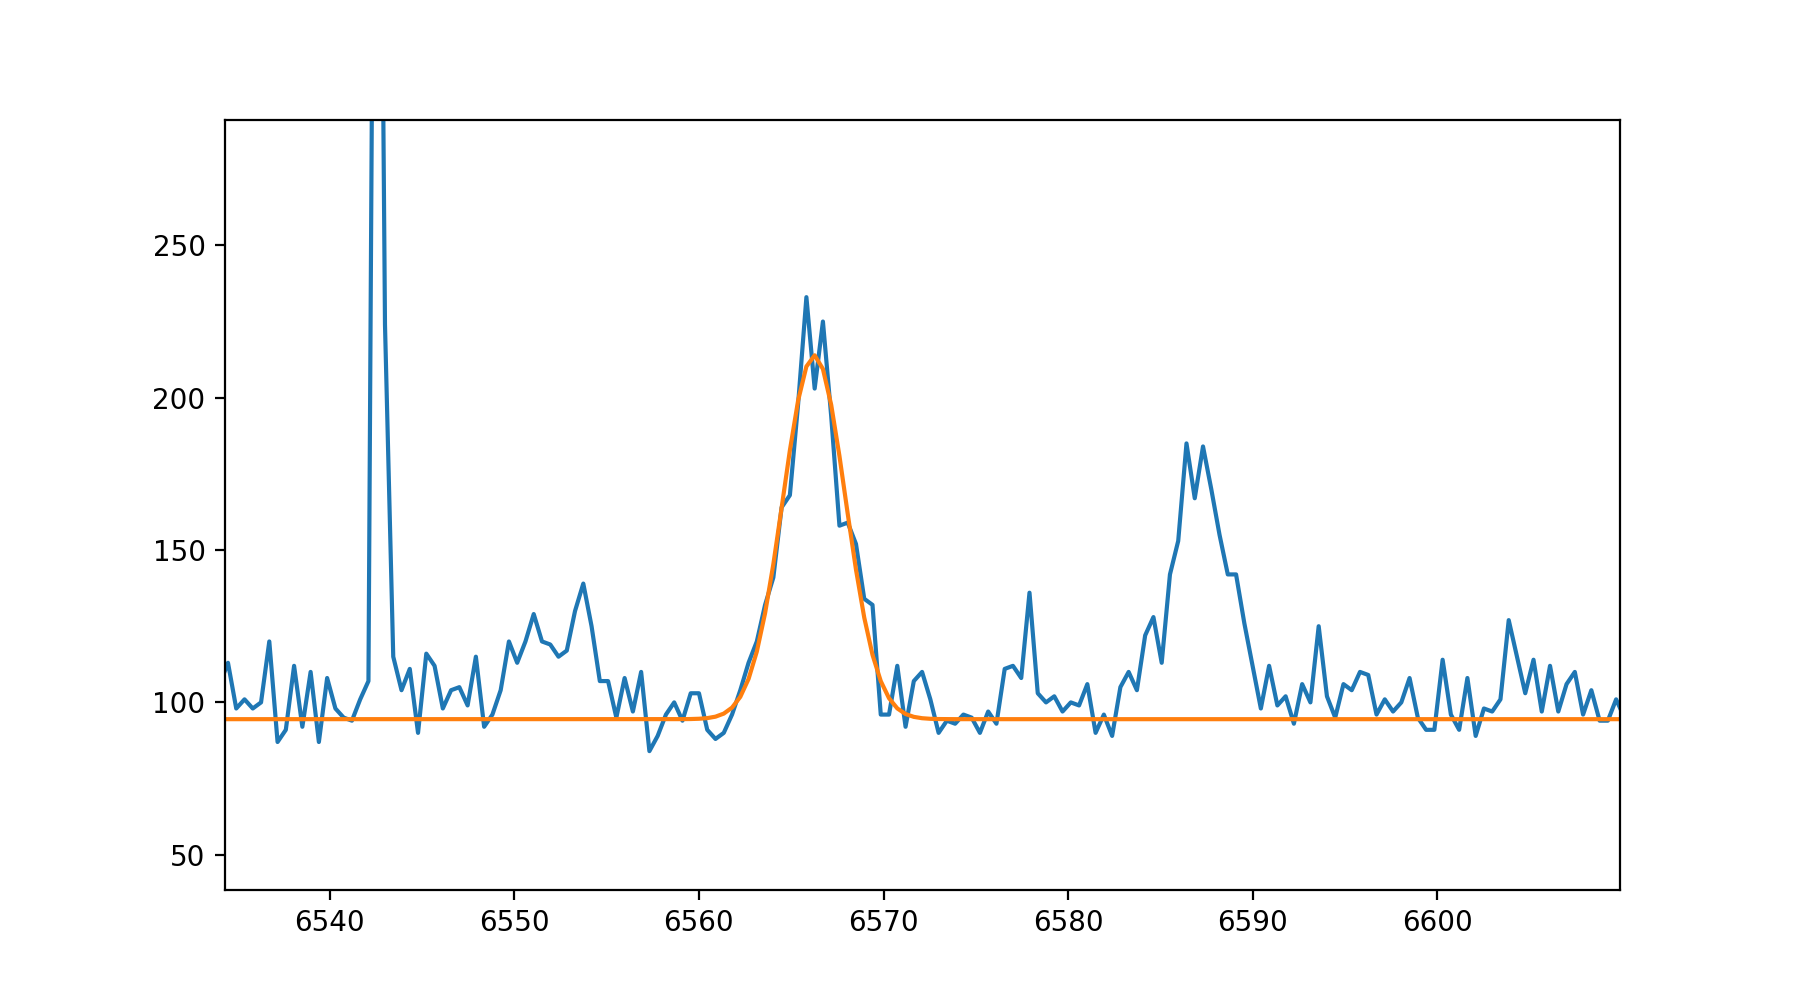

[1.19441356e+02 6.56624828e+03 1.69507743e+00 9.44932191e+01]


In [15]:
# now do the fit using a gaussian plus some background to be determined as well

ha_guess=[200.,6566,2.,100.]
print(ha_guess)

# build a sigma vector to focus on the line of interest and avoid fitting the rest of the spectrum
# sigma should be high outside of region of interest
# and low in the region of interest
sigma=wavelengths*0.+1.e10
ind=np.where((wavelengths>=6560.)&(wavelengths<=6570.))[0]
sigma[ind]=1.e-5
# fit the lamp spectrum as a sum of gaussian lines using curve_fit and our first guess
params, covariance = curve_fit(gaussian_plus_bg, wavelengths, data, p0=ha_guess,sigma=sigma)
print(params)
gau=gaussian_plus_bg(wavelengths, *params)

plt.figure(figsize=(9,5))
plt.plot(wavelengths,data)
plt.plot(wavelengths,gau)

plt.show()

print(params)


In [ ]:
#RA: 2 pi :
print(24*60)
# DEC 2pi:
print(360*60)

In [ ]:
# what do we have here???
# any idea what those lines could be?

# =================
# END OF NOTEBOOK
# =================
## beyond this is fossil code
## to be cleaned
## read at your own risk

In [ ]:
# replot the lamp spectrum using the new calibration
# Plot the spectrum and mark the centroids
fits_file = '../data/t152_spectro/lamp_thar/p67507.fits'
xaxis1,data1=read_raw_spectrum(fits_file)
wavelengths=chebyshev.chebval(xaxis1, coeffs)


iraf_file='../lamp_thar/thar_lambda.fits'
#xaxis,data=read_raw_spectrum(iraf_file)
wave,data_iraf=read_calibrated_spectrum(iraf_file)

plt.figure(figsize=(9, 5))

# ok so which lines did we actually end up using?
nguess=(len(guess))
for i in range(nguess):
    print(guess[i,1])
    plt.plot(np.full(100,guess[i,1]),np.linspace(0.,60000.,100),lw=1)


plt.plot(wavelengths,data1,label='python_calib',lw=1,color='r')
plt.plot(wave,data_iraf,label='iraf_calib',lw=1,color='b')
plt.legend()

plt.show()

In [ ]:
print(np.linspace(0.,60000.,100))

In [ ]:
# BELOW IS INTERESTING BUT NOT ESSENTIAL CODE
# TO KEEP OUT OF CURIOSITY
# A VERY DARING THOUGH NOT VERY SUCCESSFUL ATTEMPT TO AUTOMATICALLY MATCH AT LEAST A FEW LINES BASED SOLELY ON NIST INFORMATION!
# it works for a few lines but not across the whole spectrum
vals=['obs','NIST']
# select matching triplets
deltalwl=0.002
deltalF=13.5
relax_factor=0.9
nvals=len(vals)
x1=[]
y1=[]
x2=[]
y2=[]
# Create a 2D scatter plot
plt.figure(figsize=(8, 6))

for i in range(nvals):

    
    if(i==0):
        # Plot the lamp spectrum ratios
        obs_wls=allcens
        obs_amps=allamps/np.max(obs_amps)
        spectroscopic_lines = obs_wls
        amps=obs_amps
        col='r'
        leg='obs'
        al=0.3
        m='o'
        nlines_obs=len(obs_wls)
        
    if(i==1):
        al=1.
        col='b'
        leg='NIST'
        m='+'
        dataThI=[]
        dataArI=[]
        dataArII=[]
        dataThII=[]
        data=[]
        # Plot the NIST file ratios
        # Define the file path
        if(1):
            file_path = 'ThI.csv'
            # Load the data from the CSV file
            dataThI = np.loadtxt(file_path, delimiter=',', skiprows=1)  # Skip the header row
            print(file_path,len(dataThI))
        
        if(1):
            file_path = 'ArI.csv'
            # Load the data from the CSV file
            dataArI = np.loadtxt(file_path, delimiter=',', skiprows=1)  # Skip the header row
            print(file_path,len(dataArI))

        file_path = 'ArII.csv'
        # Load the data from the CSV file
        dataArII = np.loadtxt(file_path, delimiter=',', skiprows=1)  # Skip the header row
        print(file_path,len(dataArII))
        file_path = 'ThII.csv'
        # Load the data from the CSV file
        dataThII = np.loadtxt(file_path, delimiter=',', skiprows=1)  # Skip the header row
        print(file_path,len(dataThII))
        
        
#        data=np.concatenate((dataThI,dataArI,dataArII,dataThII),axis=0)
        data=np.concatenate((dataThII,dataArII,dataArI,dataThI),axis=0)
        print(len(data))
        
        # Split the data into 'wls' and 'rels' arrays
        NIST_wls = data[:, 0]  # Assumes wavelength is in the first column
        NIST_rels = data[:, 1]  # Assumes intensity is in the second column
        NIST_rels=NIST_rels/np.max(NIST_rels)
        # make sure we have the same number of lines in NIST as in OBS
        sNIST_rels=np.sort(NIST_rels)[::-1]
        relmin=sNIST_rels[nlines_obs-1]
        # or maybe relax taht constraint by some factor:
        ind=np.where(NIST_rels>=relmin*relax_factor)[0]
        NIST_wls=NIST_wls[ind]
        NIST_rels=NIST_rels[ind]

        spectroscopic_lines = NIST_wls
        amps=NIST_rels


    print('Number of lines ',vals[i],len(spectroscopic_lines))


    # Calculate the ratios lambda1/lambda2 and lambda2/lambda3
    
    deltas_1_2 = [l2 - l1 for l1, l2 in zip(spectroscopic_lines[:-1], spectroscopic_lines[1:])]
    deltas_2_3 = [l3 - l2 for l2, l3 in zip(spectroscopic_lines[1:], spectroscopic_lines[2:])]
    deltas_1_3 = [l3 - l1 for l1, l3 in zip(spectroscopic_lines[:-1], spectroscopic_lines[2:])]
    avgamps= [ np.average([a1,a2,a3]) for a1, a2, a3 in zip(amps[:-1], amps[1:],amps[2:])]
    maxamps= [ np.max([a1,a2,a3]) for a1, a2, a3 in zip(amps[:-1], amps[1:],amps[2:])]
    minamps= [ np.min([a1,a2,a3]) for a1, a2, a3 in zip(amps[:-1], amps[1:],amps[2:])]



#    print(len(deltas_1_2))
#    print(len(deltas_1_3))
#    print(len(avgamps))

    # Ensure both lists have the same size
    min_size = min(len(deltas_1_2), len(deltas_2_3),len(deltas_1_3),len(avgamps))
    deltas_1_2 = deltas_1_2[:min_size]
    deltas_2_3 = deltas_2_3[:min_size]
    deltas_1_3 = deltas_1_3[:min_size]
    ratios_1_2=np.array(deltas_1_2)/np.array(deltas_1_3)
    ratios_2_3=np.array(deltas_2_3)/np.array(deltas_1_3)
    ratios_1_2_3=np.array(deltas_1_2)/np.array(deltas_2_3)
    minmaxampratio=np.array(maxamps)/np.array(minamps)

    if(i==0):
        x1=np.log(ratios_1_2_3)
        y1=np.log(minmaxampratio)
        
    if(i==1):
        x2=np.log(ratios_1_2_3)
        y2=np.log(minmaxampratio)
    
    plt.scatter(np.log(ratios_1_2_3), np.log(minmaxampratio), c=col,marker=m, label=leg,alpha=al)
    
#plt.colorbar()

# Label the axes
plt.xlabel('$(\lambda_2-\lambda_1)/(\lambda_3-\lambda_2)$', fontsize=14)
plt.ylabel('$F_{max}/F_{min}$', fontsize=14)
#plt.xscale('log')
#plt.yscale('log')

# Add a grid
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.title('Spectroscopic Line Ratios')
#plt.show()

deltax=deltalwl
deltay=deltalF

# Initialize a list to store pairs of points that satisfy the conditions
satisfying_pairs = []
matches=[] # 0 is obs, 1 is NIST

# Loop through each pair of points from (x1, y1) and (x2, y2)
for i in range(len(x1)):
    for j in range(len(x2)):
        if np.abs(x1[i] - x2[j]) < deltax and np.abs(y1[i] - y2[j]) < deltay:
            satisfying_pairs.append((x1[i], y1[i], x2[j], y2[j]))
            matches.append((i,j))


            
# build the final line list obs vs NIST
            
for pair in satisfying_pairs:
    x1, y1, x2, y2 = pair
#    plt.scatter(x1,y1,alpha=0.)
#    plt.scatter(x2,y2)
    plt.plot([x1,x2],[y1,y2])
    print(x1,x2,y1,y2)
#    print(x1)
            
plt.show()

In [ ]:
# plot obs pixels vs obs line
print(matches)
nm=len(matches)
lobs1=np.zeros(nm)
lobs2=np.zeros(nm)
lobs3=np.zeros(nm)

lnist1=np.zeros(nm)
lnist2=np.zeros(nm)
lnist3=np.zeros(nm)

for i in range(nm):
    j,k=matches[i]
#    print(j,k)
    lobs1[i]=obs_wls[:-1][j]
    lobs2[i]=obs_wls[1:][j]
    lobs3[i]=obs_wls[2:][j]
#    print(np.log((lobs2[i]-lobs1[i])/(lobs3[i]-lobs2[i])))
    lnist1[i]=NIST_wls[:-1][k]
    lnist2[i]=NIST_wls[1:][k]
    lnist3[i]=NIST_wls[2:][k]
#    print(np.log((lnist2[i]-lnist1[i])/(lnist3[i]-lnist2[i])))

lobs=[]
lnist=[]
lobs=np.append(lobs,[lobs1,lobs2,lobs3])
lnist=np.append(lnist,[lnist1,lnist2,lnist3])    

plt.figure(figsize=(6,6))
plt.scatter(lobs,lnist)
plt.show()